<a href="https://colab.research.google.com/github/ncrowder/python/blob/main/13_Feature_Engineering_II_Automated_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!wget https://raw.githubusercontent.com/mfenner1/mlwpy_code/refs/heads/master/mlwpy.py

--2025-11-25 21:35:15--  https://raw.githubusercontent.com/mfenner1/mlwpy_code/refs/heads/master/mlwpy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11133 (11K) [text/plain]
Saving to: ‘mlwpy.py.1’

mlwpy.py.1          100%[===================>]  10.87K  --.-KB/s    in 0.001s  

2025-11-25 21:35:16 (11.1 MB/s) - ‘mlwpy.py.1’ saved [11133/11133]



In [14]:
import mlwpy

In [15]:
# setup
from mlwpy import *
%matplotlib inline

# sklearn got chirpy again
warnings.filterwarnings('ignore',
                        category=sklearn.exceptions.ConvergenceWarning,
                        module='sklearn')

kwargs = {'test_size':.25, 'random_state':42}

iris = datasets.load_iris()
tts = skms.train_test_split(iris.data, iris.target, **kwargs)
(iris_train,     iris_test,
 iris_train_tgt, iris_test_tgt) = tts

wine = datasets.load_wine()
tts = skms.train_test_split(wine.data, wine.target, **kwargs)
(wine_train,     wine_test,
 wine_train_tgt, wine_test_tgt) = tts

diabetes = datasets.load_diabetes()
tts = skms.train_test_split(diabetes.data, diabetes.target, **kwargs)
(diabetes_train_ftrs, diabetes_test_ftrs,
 diabetes_train_tgt,  diabetes_test_tgt) = tts

# these are entire datasets
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

In [16]:
print(wine_df.var())

alcohol                                      0.6591
malic_acid                                   1.2480
ash                                          0.0753
alcalinity_of_ash                           11.1527
magnesium                                  203.9893
total_phenols                                0.3917
flavanoids                                   0.9977
nonflavanoid_phenols                         0.0155
proanthocyanins                              0.3276
color_intensity                              5.3744
hue                                          0.0522
od280/od315_of_diluted_wines                 0.5041
proline                                 99,166.7174
dtype: float64


In [17]:
print(wine_df['hue'].max() - wine_df['hue'].min())

1.23


In [18]:
print(wine_df['proline'].max() - wine_df['proline'].min())

1402.0


In [19]:
# variance selection example without scaling
varsel = ftr_sel.VarianceThreshold(threshold=1.0)
varsel.fit_transform(wine_train)

print("first example")
print(varsel.fit_transform(wine_train)[0],
      wine_train[0, wine_train.var(axis=0) > 1.0], sep='\n')

first example
[   2.36   18.6   101.      3.24    5.68 1185.  ]
[   2.36   18.6   101.      3.24    5.68 1185.  ]


In [20]:
print(varsel.get_support())

[False  True False  True  True False  True False False  True False False
  True]


In [21]:
keepers_idx = varsel.get_support()
keepers = np.array(wine.feature_names)[keepers_idx]
print(keepers)

['malic_acid' 'alcalinity_of_ash' 'magnesium' 'flavanoids'
 'color_intensity' 'proline']


In [22]:
minmax = skpre.MinMaxScaler().fit_transform(wine_train)
print(np.sort(minmax.var(axis=0)))

[0.0223 0.0264 0.0317 0.0331 0.0361 0.0447 0.0473 0.0492 0.0497 0.0569
 0.058  0.0587 0.071 ]


In [23]:
# scaled variance selection example
pipe = pipeline.make_pipeline(skpre.MinMaxScaler(),
                              ftr_sel.VarianceThreshold(threshold=0.05))
pipe.fit_transform(wine_train).shape

# pipe.steps is list of (name, step_object)
keepers_idx = pipe.steps[1][1].get_support()
print(np.array(wine.feature_names)[keepers_idx])

['nonflavanoid_phenols' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


In [24]:
# cov(X,Y) = np.dot(X-E(X), Y-E(Y)) / n
n = len(diabetes_train_ftrs)

# abbreviate names
x = diabetes_train_tgt[np.newaxis,:]
y = diabetes_train_ftrs
cov_via_dot = np.dot(x-x.mean(), y-y.mean()) / n

# compute all covariances, extract the ones between ftr and target
# bias=True to divide by n instead of n-1; np.cov defaults to bias=False
cov_via_np  = np.cov(diabetes_train_ftrs, diabetes_train_tgt,
                     rowvar=False, bias=True)[-1, :-1]
print(np.allclose(cov_via_dot, cov_via_np))

True


In [25]:
# np.var default ddof=0 equates to bias=True
# np.corrcoef is a bit of a hot mess to extract values from

# cov()/sqrt(var() var())
cor_via_cov = cov_via_np / np.sqrt(np.var(diabetes_train_tgt) *
                                   np.var(diabetes_train_ftrs, axis=0))
cor_via_np = np.corrcoef(diabetes_train_ftrs, diabetes_train_tgt,
                         rowvar=False)[-1, :-1]
print(np.allclose(cor_via_cov, cor_via_np))

True


In [26]:
# note, we use the squres of the correlations ... r^2
corrs = np.corrcoef(diabetes_train_ftrs,
                    diabetes_train_tgt, rowvar=False)[-1, :-1]
cor_order = np.argsort(corrs**2) # r^2 (!)
cor_names = np.array(diabetes.feature_names)[cor_order[::-1]]

# and sklearn's f_regression calculation
f_scores = ftr_sel.f_regression(diabetes_train_ftrs,
                                diabetes_train_tgt)[0]
freg_order = np.argsort(f_scores)
freg_names = np.array(diabetes.feature_names)[freg_order[::-1]]

# numpy arrays don't like comparing strings
print(tuple(cor_names) == tuple(freg_names))

True


In [27]:
xs = np.linspace(-10,10,1000).reshape(-1,1)
data = np.c_[xs, np.random.uniform(-10,10,xs.shape)]
tgt = (np.cos(xs) > 0).flatten()

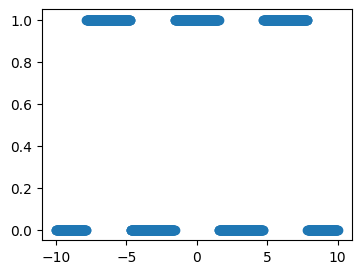

In [28]:
plt.figure(figsize=(4,3))
plt.scatter(data[:,0], tgt);

In [29]:
mi = ftr_sel.mutual_info_classif(data, tgt,
                                 discrete_features=False)
print(mi)

[0.6815 0.0029]


In [30]:
xs = np.linspace(-10,10,1000).reshape(-1,1)
data = np.c_[xs, np.random.uniform(-10,10,xs.shape)]
tgt = np.cos(xs).flatten()

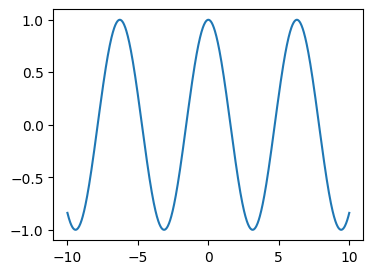

In [31]:
plt.figure(figsize=(4,3))
plt.plot(data[:,0], tgt);

In [32]:
print(ftr_sel.f_regression(data, tgt)[0],
      ftr_sel.mutual_info_regression(data, tgt),
      sep='\n')

[0. 0.]
[1.9356 0.    ]


In [33]:
xs, ys = np.mgrid[-2:2:.2, -2:2:.2]
c_tgt = (ys > xs**2).flatten()

# basically, turn r_tgt off if y<x**2
r_tgt = ((xs**2 + ys**2)*(ys>xs**2))

data = np.c_[xs.flat, ys.flat]

# print out a few examples
combined = np.c_[data, c_tgt, r_tgt.flat]
combined[np.arange(0,401,66)]

array([[-2. , -2. ,  0. ,  0. ],
       [-1.4, -0.8,  0. ,  0. ],
       [-0.8,  0.4,  0. ,  0. ],
       [-0.2,  1.6,  1. ,  2.6],
       [ 0.6, -1.2,  0. ,  0. ],
       [ 1.2,  0. ,  0. ,  0. ],
       [ 1.8,  1.2,  0. ,  0. ]])

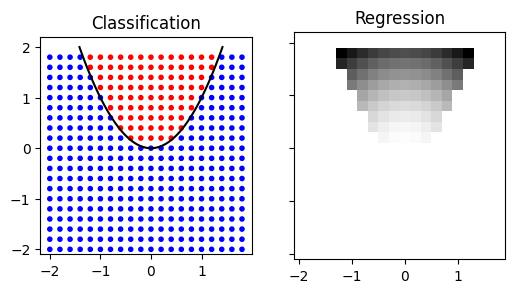

In [34]:
fig,axes = plt.subplots(1,2, figsize=(6,3), sharey=True)
axes[0].scatter(xs, ys, c=np.where(c_tgt, 'r', 'b'), marker='.')
axes[0].set_aspect('equal');

bound_xs = np.linspace(-np.sqrt(2), np.sqrt(2), 100)
bound_ys = bound_xs**2
axes[0].plot(bound_xs, bound_ys, 'k')
axes[0].set_title('Classification')

axes[1].pcolormesh(xs, ys, r_tgt, shading='auto', cmap='binary')
axes[1].set_aspect('equal')
axes[1].set_title('Regression');

In [35]:
print(ftr_sel.mutual_info_classif(data, c_tgt,
                                  discrete_features=False, random_state=42))

[0.0947 0.1976]


In [36]:
print(ftr_sel.mutual_info_regression(data, r_tgt.flat, discrete_features=False))

[0.0512 0.4861]


In [37]:
ftrsel = ftr_sel.SelectKBest(ftr_sel.mutual_info_classif, k=5)
ftrsel.fit_transform(wine_train, wine_train_tgt)

# extract names
keepers_idx = ftrsel.get_support()
print(np.array(wine.feature_names)[keepers_idx])

['flavanoids' 'color_intensity' 'hue' 'od280/od315_of_diluted_wines'
 'proline']


In [38]:
ftrsel = ftr_sel.SelectKBest(ftr_sel.f_classif, k=5)
ftrsel.fit_transform(wine_train, wine_train_tgt)

keepers_idx = ftrsel.get_support()
print(np.array(wine.feature_names)[keepers_idx])

['alcohol' 'flavanoids' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


In [39]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.f_regression,
                                  percentile=25)
ftrsel.fit_transform(diabetes_train_ftrs,
                     diabetes_train_tgt)

print(np.array(diabetes.feature_names)[ftrsel.get_support()])

['bmi' 'bp' 's5']


In [40]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.mutual_info_regression,
                                  percentile=25)
ftrsel.fit_transform(diabetes_train_ftrs,
                     diabetes_train_tgt)

print(np.array(diabetes.feature_names)[ftrsel.get_support()])

['bmi' 's4' 's5']


In [41]:
ftrsel = ftr_sel.SelectFromModel(ensemble.RandomForestClassifier(),
                                 threshold='mean') # default
ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])

['flavanoids' 'color_intensity' 'od280/od315_of_diluted_wines' 'proline']


In [42]:
lmlr = linear_model.LogisticRegression
# default solver if lbfgs, which complains about L1 now
# so switching to liblinear solver
ftrsel = ftr_sel.SelectFromModel(lmlr(penalty='l1',
                                 solver='liblinear')) # thesh is "small" coeffs
ftrsel.fit_transform(wine_train, wine_train_tgt)

print(np.array(wine.feature_names)[ftrsel.get_support()])

['alcohol' 'malic_acid' 'ash' 'alcalinity_of_ash' 'magnesium' 'flavanoids'
 'proanthocyanins' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


In [43]:
ftrsel = ftr_sel.RFE(ensemble.RandomForestClassifier(),
                     n_features_to_select=5)

res = ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])

['alcohol' 'flavanoids' 'color_intensity' 'od280/od315_of_diluted_wines'
 'proline']


In [44]:
# statisticians be warned (see end-of-chapter)
# this picks based on feature weights (coefficients)
# not on significance of coeffs nor on r^2/anova/F of (whole) model
ftrsel = ftr_sel.RFE(linear_model.LinearRegression(),
                     n_features_to_select=5)
ftrsel.fit_transform(wine_train, wine_train_tgt)
print(np.array(wine.feature_names)[ftrsel.get_support()])

['alcohol' 'total_phenols' 'flavanoids' 'hue'
 'od280/od315_of_diluted_wines']


In [45]:
# all the 1s are selected; non-1s are when they were dropped
# go to the estimator and ask its coefficients
print(ftrsel.ranking_,
      ftrsel.estimator_.coef_, sep='\n')

[1 5 2 4 9 1 1 3 7 6 1 1 8]
[-0.2164  0.1281 -0.3936 -0.6394 -0.3572]


In [46]:
# the order for the five 1s
keepers_idx = np.argsort(np.abs(ftrsel.estimator_.coef_))
# find the indexes of the 1s and get their ordering
keepers_order_idx = np.where(ftrsel.ranking_ == 1)[0][keepers_idx]
print(np.array(wine.feature_names)[keepers_order_idx])

['total_phenols' 'alcohol' 'od280/od315_of_diluted_wines' 'flavanoids'
 'hue']


In [47]:
skms.cross_val_score(linear_model.LogisticRegression(),
                     wine.data, wine.target)

array([0.8889, 0.9444, 0.9444, 1.    , 1.    ])

In [48]:
# do it
# theshold is "small" coeffs
lmlr = linear_model.LogisticRegression
ftrsel = ftr_sel.SelectFromModel(lmlr(penalty='l1',
                                      solver='liblinear'))

pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())
skms.cross_val_score(pipe, wine.data, wine.target)

array([0.9167, 0.9444, 0.9444, 1.    , 1.    ])

In [49]:
ftrsel = ftr_sel.RFE(ensemble.RandomForestClassifier(),
                     n_features_to_select=5)
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())
skms.cross_val_score(pipe, wine.data, wine.target)

array([0.8889, 0.8889, 0.9444, 0.9429, 0.9714])

In [50]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.mutual_info_classif,
                                  percentile=25)
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())
skms.cross_val_score(pipe, wine.data, wine.target)

array([0.8611, 0.9167, 0.9722, 0.9714, 0.9714])

In [51]:
ftrsel = ftr_sel.SelectPercentile(ftr_sel.mutual_info_classif, percentile=25)
pipe = pipeline.make_pipeline(ftrsel, linear_model.LogisticRegression())

param_grid = {'selectpercentile__percentile':[5,10,15,20,25]}
grid = skms.GridSearchCV(pipe, param_grid=param_grid, cv=3)
grid.fit(wine.data, wine.target)

print(grid.best_params_)
print(grid.best_score_)

{'selectpercentile__percentile': 20}
0.9161016949152542


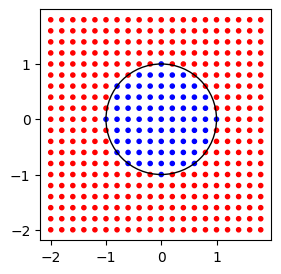

In [52]:
xs, ys = np.mgrid[-2:2:.2, -2:2:.2]
tgt = (xs**2 + ys**2 > 1).flatten()
data = np.c_[xs.flat, ys.flat]

fig, ax = plt.subplots(figsize=(4,3))

# draw the points
ax.scatter(xs, ys, c=np.where(tgt, 'r', 'b'), marker='.')
ax.set_aspect('equal');

# draw the circle boundary
circ = plt.Circle((0,0), 1, color='k', fill=False)
ax.add_patch(circ);

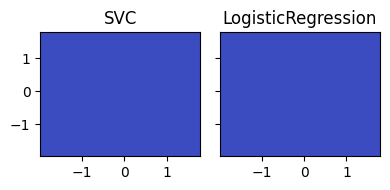

In [53]:
shootout_linear = [svm.SVC(kernel='linear'),
                   linear_model.LogisticRegression()]

fig, axes = plt.subplots(1,2,figsize=(4,2), sharey=True)
for mod, ax in zip(shootout_linear, axes):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod))
plt.tight_layout()

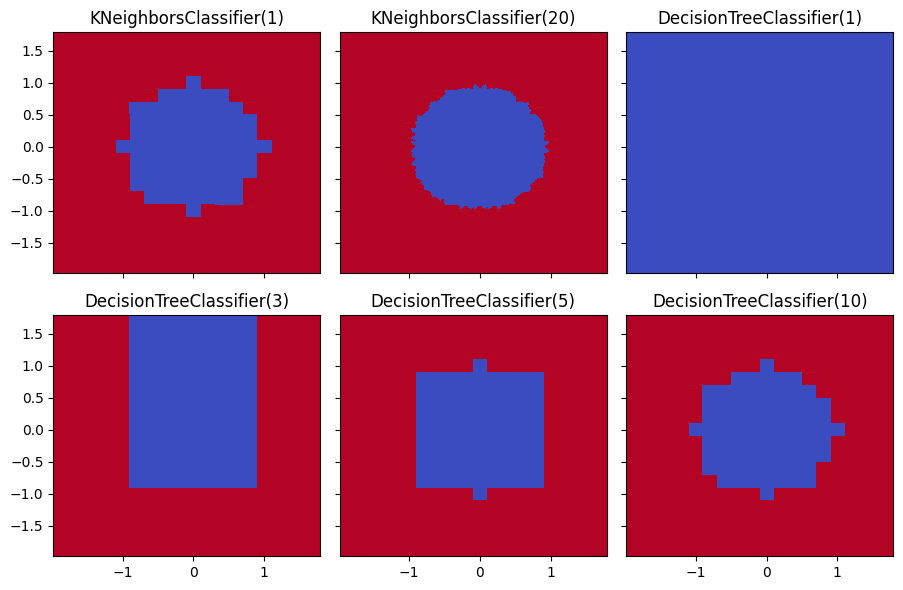

In [54]:
# create some non-linear learning models
knc_p, dtc_p = [1,20], [1,3,5,10]
KNC = neighbors.KNeighborsClassifier
DTC = tree.DecisionTreeClassifier
shootout_nonlin = ([(KNC(n_neighbors=p), p) for p in knc_p] +
                   [(DTC(max_depth=p), p)   for p in dtc_p ])

# plot 'em
fig, axes = plt.subplots(2,3,figsize=(9, 6),
                        sharex=True, sharey=True)
for (mod, param), ax in zip(shootout_nonlin, axes.flat):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod) + "({})".format(param))
plt.tight_layout()

augmented data shape: (400, 4)
first row: [-2. -2.  4.  4.]


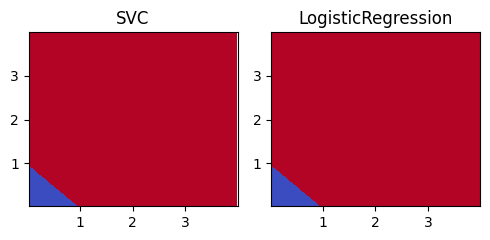

In [55]:
new_data = np.concatenate([data, data**2], axis=1)
print("augmented data shape:", new_data.shape)
print("first row:", new_data[0])

fig, axes = plt.subplots(1,2,figsize=(5,2.5))
for mod, ax in zip(shootout_linear, axes):
    # using the squares for prediction and graphing
    plot_boundary(ax, new_data, tgt, mod, [2,3])
    ax.set_title(get_model_name(mod))
plt.tight_layout()

In [56]:
# pick a few points to show off the before/after differences
test_points = np.array([[.5,.5],
                       [-1, -1.25]])

# wonderful trick from trig class:
# if we walk around circle (fractions of pi),
# sin/cos give x and y value from pi
circle_pts = np.linspace(0,2*np.pi,100)
circle_xs, circle_ys = np.sin(circle_pts), np.cos(circle_pts)

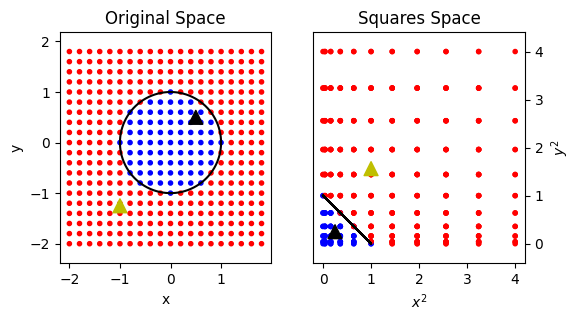

In [57]:
fig, axes = plt.subplots(1,2, figsize=(6,3))

labels = [('x',     'y',     'Original Space'),
          ('$x^2$', '$y^2$', 'Squares Space')]

funcs = [lambda x:x,    # for original ftrs
         lambda x:x**2] # for squared ftrs

for ax, func, lbls in zip(axes, funcs, labels):
    ax.plot(func(circle_xs), func(circle_ys), 'k')
    ax.scatter(*func(data.T), c=np.where(tgt, 'r', 'b'), marker='.')
    ax.scatter(*func(test_points.T), c=['k', 'y'], s=100, marker='^')

    ax.axis('equal')
    ax.set_xlabel(lbls[0])
    ax.set_ylabel(lbls[1])
    ax.set_title(lbls[2])

axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right");

In [58]:
k_data = metrics.pairwise.polynomial_kernel(data, data,
                                            degree=2) # squares
print('first example: ', data[0])

print('example in   original features:', data[0].shape)
print('example in kernelized features:', k_data[0].shape)

print('# examples in both:', len(data), len(k_data))

first example:  [-2. -2.]
example in   original features: (2,)
example in kernelized features: (400,)
# examples in both: 400 400


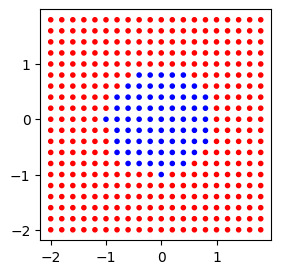

In [59]:
fig, ax = plt.subplots(figsize=(4,3))

# learn from k_data instead of original data
preds  = (linear_model.LogisticRegression()
                      .fit(k_data, tgt)
                      .predict(k_data))

ax.scatter(xs, ys, c=np.where(preds, 'r', 'b'), marker='.')
ax.set_aspect('equal')

In [60]:
from sklearn.base import TransformerMixin

class PolyKernel(TransformerMixin):
    def __init__(self, degree):
        self.degree = degree

    def transform(self, ftrs):
        pk = metrics.pairwise.pairwise_kernels
        return pk(ftrs, self.ftrs, metric='poly', degree=self.degree)

    def fit(self, ftrs, tgt=None):
        self.ftrs = ftrs
        return self

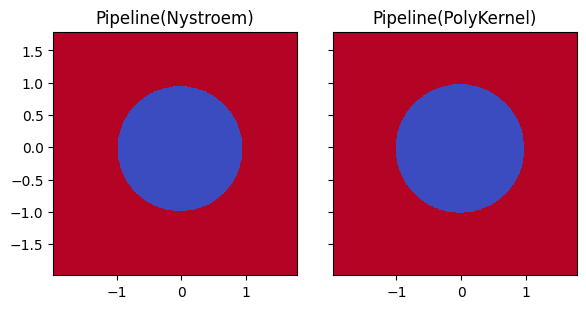

In [61]:
from sklearn import kernel_approximation

kn = kernel_approximation.Nystroem(kernel='polynomial',
                                   degree=2, n_components=6)
LMLR = linear_model.LogisticRegression()
k_logreg1 = pipeline.make_pipeline(kn, LMLR)
k_logreg2 = pipeline.make_pipeline(PolyKernel(2), LMLR)

shootout_fancy = [(k_logreg1, 'Nystroem'),
                  (k_logreg2, 'PolyKernel')]

fig, axes = plt.subplots(1,2,figsize=(6,3), sharey=True)
for (mod, kernel_name), ax in zip(shootout_fancy, axes):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod)+"({})".format(kernel_name))
    ax.set_aspect('equal')
plt.tight_layout()

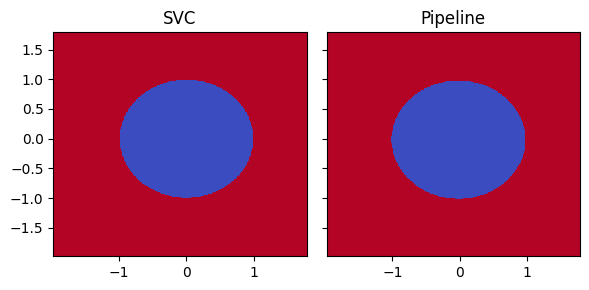

In [62]:
k_logreg = pipeline.make_pipeline(PolyKernel(2),
                                  linear_model.LogisticRegression())

shootout_fancy = [svm.SVC(kernel='poly', degree=2),
                  k_logreg]

fig, axes = plt.subplots(1,2,figsize=(6,3), sharey=True)
for mod, ax in zip(shootout_fancy, axes):
    plot_boundary(ax, data, tgt, mod, [0,1])
    ax.set_title(get_model_name(mod))
plt.tight_layout()

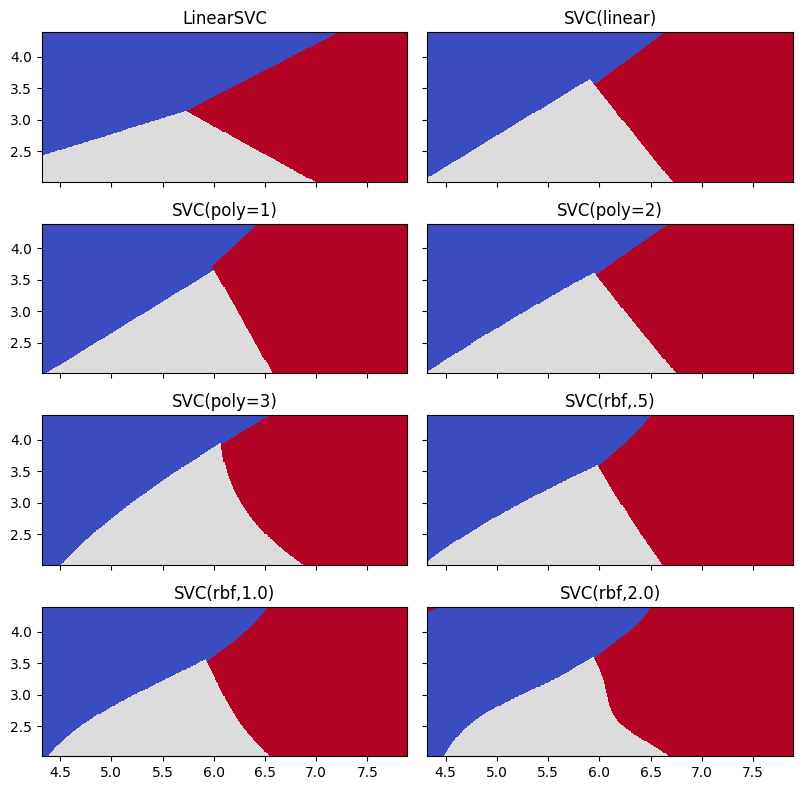

In [63]:
# first three are linear (but different)
sv_classifiers = {"LinearSVC"   : svm.LinearSVC(),
                  "SVC(linear)" : svm.SVC(kernel='linear'),

                  "SVC(poly=1)" : svm.SVC(kernel='poly', degree=1),
                  "SVC(poly=2)" : svm.SVC(kernel='poly', degree=2),
                  "SVC(poly=3)" : svm.SVC(kernel='poly', degree=3),

                  "SVC(rbf,.5)" : svm.SVC(kernel='rbf', gamma=0.5),
                  "SVC(rbf,1.0)": svm.SVC(kernel='rbf', gamma=1.0),
                  "SVC(rbf,2.0)": svm.SVC(kernel='rbf', gamma=2.0)}

fig, axes = plt.subplots(4,2,figsize=(8,8),sharex=True, sharey=True)
for ax, (name, mod) in zip(axes.flat, sv_classifiers.items()):
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
plt.tight_layout()

In [64]:
digits = datasets.load_digits()

param_grid = {"gamma" : np.logspace(-10, 1, 11, base=2),
              "C"     : [0.5, 1.0, 2.0]}

svc = svm.SVC(kernel='rbf')

grid_model = skms.GridSearchCV(svc, param_grid = param_grid,
                               cv=10)
grid_model.fit(digits.data, digits.target);

In [65]:
grid_model.best_params_

{'C': 2.0, 'gamma': np.float64(0.0009765625)}

In [66]:
my_gamma = grid_model.best_params_['gamma']
my_svc = svm.SVC(kernel='rbf', **grid_model.best_params_)
scores = skms.cross_val_score(my_svc,
                              digits.data, digits.target,
                              cv=10,
                              scoring='f1_macro')
print(scores)
print("{:5.3f}".format(scores.mean()))

[0.9665 1.     0.9493 0.9836 0.9944 0.9889 0.9944 0.9944 0.9769 0.9666]
0.981


In [67]:
data = np.array([[1, 2, 4, 5],
                   [2.5,.75,5.25,3.5]]).T
mean = data.mean(axis=0)
centered_data = data - mean

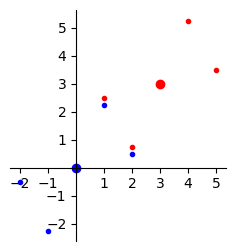

In [68]:
fig, ax = plt.subplots(figsize=(3,3))

# original data in red; mean is larger dot
ax.plot(*data.T, 'r.')
ax.plot(*mean, 'ro')

# centered data in blue, mean is larger dot (and at (0,0))
ax.plot(*centered_data.T, 'b.')
ax.plot(*centered_data.mean(axis=0), 'bo')

#ax.set_aspect('equal');
high_school_style(ax)

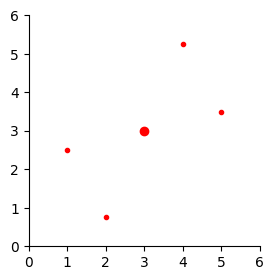

In [69]:
# we can reproduce the original data
fig,ax = plt.subplots(figsize=(3,3))
orig_data = centered_data + mean
plt.plot(*orig_data.T, 'r.')
plt.plot(*orig_data.mean(axis=0), 'ro')

ax.set_xlim((0,6))
ax.set_ylim((0,6))
high_school_style(ax)

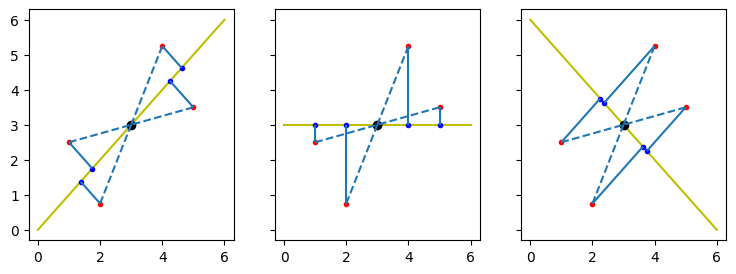

In [70]:
fig, axes = plt.subplots(1,3,figsize=(9,3), sharex=True,sharey=True)
xs = np.linspace(0,6,30)
lines = [(1,0), (0,3), (-1,6)]
data = np.array([[1, 2, 4, 5],
                   [2.5,.75,5.25,3.5]]).T
plot_lines_and_projections(axes, lines, data, xs)

Lengths: [5.6067 1.2683]


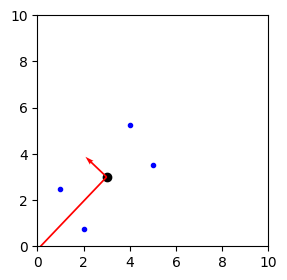

In [71]:
# draw data
ax = plt.gca()
ax.scatter(data[:,0], data[:,1], c='b', marker='.')

# draw mean
mean = np.mean(data, axis=0, keepdims=True)
centered_data = data - mean
ax.scatter(*mean.T, c='k')

# compute PCA
pca = decomposition.PCA()
P = pca.fit_transform(centered_data)

# extract useful bits for drawing
directions = pca.components_
lengths = pca.explained_variance_
print("Lengths:", lengths)
var_wgt_prindirs = -np.diag(lengths).dot(directions) # negate so point up/right

# draw principal axes
sane_quiver(var_wgt_prindirs, ax,
            origin=np.mean(data, axis=0),
            colors='r')
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_aspect('equal')

In [72]:
print(np.allclose(np.cov(data, rowvar=False),
                  np.cov(centered_data, rowvar=False)))

True


In [73]:
orig_cov = np.cov(centered_data, rowvar=False)
print(orig_cov)
print(np.diag(orig_cov).sum())

[[3.3333 2.1667]
 [2.1667 3.5417]]
6.875


In [74]:
EPS = 2.2e-16 # EPS (epsilon) is computer sciency for "really small"
p_cov = np.cov(P, rowvar=False)
p_cov[p_cov<EPS] = 0.0  # throw out "really small" values
print(p_cov)
print(p_cov.sum())

[[5.6067 0.    ]
 [0.     1.2683]]
6.874999999999999


In [75]:
def make_rotation(theta):
    ''' ccw rotation of theta when it post-multiplies
        a row vector (an example) '''
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta),  np.cos(theta)]]).T

In [76]:
spacing = np.linspace(0,2*np.pi,17)
points  = np.c_[np.sin(spacing), np.cos(spacing)] # sin/cos walk around circle
two_points = points[[0,3]]

rot = make_rotation(np.pi/8) # 1/16th turn degrees ccw
scale = np.diag([2,.5])

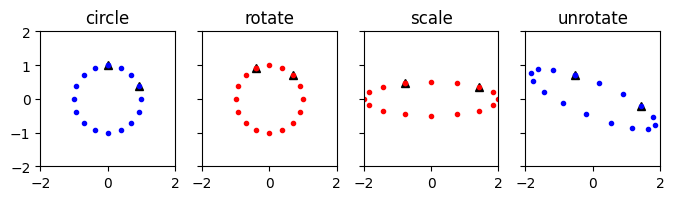

In [77]:
fig, axes = plt.subplots(1,4,figsize=(8,2), sharey=True)

# original vanilla circle
axes[0].plot(*two_points.T, 'k^')
axes[0].plot(*points.T, 'b.')

# make a rotation
axes[1].plot(*np.dot(two_points, rot).T, 'k^')
axes[1].plot(*np.dot(points, rot).T, 'r.')

# stretch along x and y axes
axes[2].plot(*two_points.dot(rot).dot(scale).T, 'k^')
axes[2].plot(*points.dot(rot).dot(scale).T, 'r.')

# undo initial rotation
axes[3].plot(*two_points.dot(rot).dot(scale).dot(rot.T).T, 'k^')
axes[3].plot(*points.dot(rot).dot(scale).dot(rot.T).T, 'b.')

names = ['circle', 'rotate', 'scale', 'unrotate']
for ax,name in zip(axes,names):
    ax.set_aspect('equal')
    ax.set_title(name)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

In [78]:
def signs_like(A, B):
    ' produce new A,B with signs of A '
    assert np.allclose(np.abs(A), np.abs(B))
    signs = np.sign(A) * np.sign(B)
    return A, B * signs
signs_like([1,-1], [1,1])

([1, -1], array([ 1, -1]))

In [79]:
N = len(centered_data)

U, s, Vt = np.linalg.svd(centered_data, full_matrices=False)
S = np.diag(s)
print(np.allclose(centered_data, U.dot(S).dot(Vt)))

True


In [80]:
# align signs -
# note, U.S.Vt won't give centered now b/c
# U,Vt work together and we monkeyed with Vt
_, Vt = signs_like(pca.components_, Vt)
V = Vt.T

# directions come from Vt;  amounts come from S
# div. by n-1 to get unbiased ... see EOC
print(all((np.allclose(pca.components_,         Vt),
           np.allclose(pca.explained_variance_, s**2/(N-1)),
           np.allclose(P,                       centered_data.dot(V)))))

True


In [81]:
print('original covariance:\n', orig_cov)
print('centered covariance:\n',
      centered_data.T.dot(centered_data) / (N-1))

original covariance:
 [[3.3333 2.1667]
 [2.1667 3.5417]]
centered covariance:
 [[3.3333 2.1667]
 [2.1667 3.5417]]


In [82]:
eigval, eigvec = np.linalg.eig(orig_cov)

# two differences:
# 1.  eigvals aren't ordered high to low (S from svd is ordered)
# 2.  final signs with SVD go through V *and* U, eigvec bit different
order = np.argsort(eigval)[::-1]
print(np.allclose(eigval[order], s**2/(N-1)))

_,ev = signs_like(Vt,eigvec[:,order])
print(np.allclose(ev, Vt))

True
True


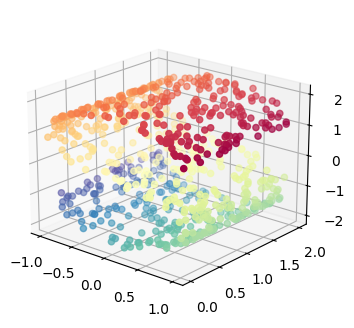

In [83]:
from mpl_toolkits.mplot3d import Axes3D
import sklearn.manifold as manifold
data_3d, color = datasets.make_s_curve(n_samples=750,
                                       random_state=42)

cmap = plt.cm.Spectral
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
ax.scatter(*data_3d.T, c=color, cmap=cmap)
ax.view_init(20, -50)

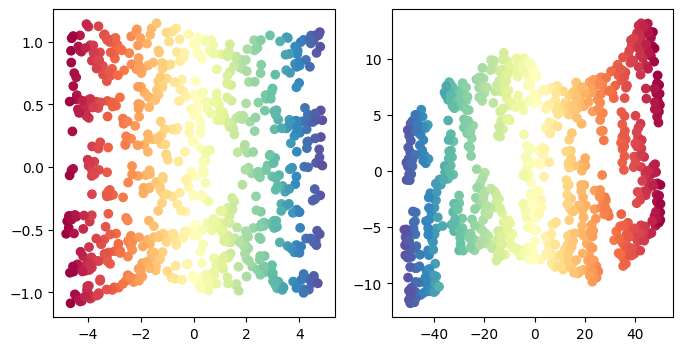

In [84]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
n_components = 2

# method 1:  map to 2D using isomap
isomap = manifold.Isomap(n_neighbors=10, n_components=n_components)
data_2d = isomap.fit_transform(data_3d)
axes[0].scatter(*data_2d.T, c=color, cmap=cmap)

# method 2:  map to 2D using TSNE
tsne = manifold.TSNE(n_components=n_components,
                     init='pca',
                     random_state=42)
data_2d = tsne.fit_transform(data_3d)
axes[1].scatter(*data_2d.T, c=color, cmap=cmap);